In [7]:
!git clone https://github.com/iMohammad97/anomaly_detection

Cloning into 'anomaly_detection'...
remote: Enumerating objects: 4493, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 4493 (delta 22), reused 42 (delta 21), pack-reused 4446 (from 2)
Receiving objects: 100% (4493/4493), 426.44 MiB | 21.37 MiB/s, done.
Resolving deltas: 100% (1916/1916), done.
Updating files: 100% (3090/3090), done.


In [8]:
# @title Imports

import os
import glob
import re
import pandas as pd
import numpy as np
import plotly.express as px

In [9]:
# @title Presentation

################################################################################
# User Inputs / Config
################################################################################

# The base directory containing your "Anomaly_Task#_..." folders
base_directory = "/content/anomaly_detection/Experiments/Task4_5/Results"

# The known time-series IDs
time_series_ids = ["2", "37", "45", "23", "43", "21", "4", "8", "11", "20", "50", "51", "69", "31", "6"]

# Regex pattern to parse folder names such as:
# "Anomaly_Task4_AE_Transformer_MSE" → Task=4, Model=AE, Architecture=Transformer, LossFunction=MSE
folder_pattern = re.compile(r'^Anomaly_Task(\d+)_(\w+)_(\w+)_(\w+)$')

# We expect CSVs named like "lstm_ae_results_ep200_ts23.csv"
# We'll parse the time-series id via regex: '_ts(\d+).csv'
tsid_pattern = re.compile(r'_ts(\d+)\.csv$')

################################################################################
# 1) Gather all results from .csv files
################################################################################
rows = []  # We'll accumulate data here

folder_names = sorted(os.listdir(base_directory))
for folder_name in folder_names:
    folder_path = os.path.join(base_directory, folder_name)
    if not os.path.isdir(folder_path):
        continue  # skip non-folders

    match = folder_pattern.match(folder_name)
    if not match:
        # If the folder doesn't match "Anomaly_Task(\d+)_(\w+)_(\w+)_(\w+)", skip it
        continue

    # Extract from folder_name
    task_num = match.group(1)
    model_str = match.group(2)
    architecture_str = match.group(3)
    loss_func = match.group(4)

    # Find CSV files inside this folder
    csv_files = sorted(glob.glob(os.path.join(folder_path, "*_results*_ts*.csv")))
    for csv_path in csv_files:
        csv_name = os.path.basename(csv_path)

        # Parse time-series ID from filename
        ts_match = tsid_pattern.search(csv_name)
        if not ts_match:
            continue
        ts_id = ts_match.group(1)
        if ts_id not in time_series_ids:
            continue

        # Read the CSV
        df_csv = pd.read_csv(csv_path)
        if df_csv.empty:
            continue

        # Typically 1 row, so take the first:
        row_data = df_csv.iloc[0].to_dict()

        # Add folder-level fields
        row_data["FolderName"]   = folder_name
        row_data["Task"]         = task_num
        row_data["Model"]        = model_str
        row_data["Architecture"] = architecture_str
        row_data["LossFunction"] = loss_func
        row_data["TimeSeriesID"] = ts_id

        # Derive the corresponding plot .html path:
        # e.g. "lstm_ae_results_ep200_ts23.csv" → "lstm_ae_plot_ep200_ts23.html"
        html_path = csv_path.replace("_results_", "_plot_").replace(".csv", ".html")
        if os.path.exists(html_path):
            row_data["PlotHTMLPath"] = html_path
        else:
            row_data["PlotHTMLPath"] = None

        rows.append(row_data)

all_results_df = pd.DataFrame(rows)

################################################################################
# 2) Display *all* rows and save the combined .csv
################################################################################
if all_results_df.empty:
    print("No CSV data found. Check your directory paths and naming patterns.")
else:
    # Show all rows
    pd.set_option('display.max_rows', None)
    display(all_results_df)

    # Save
    all_results_csv_path = os.path.join(base_directory, "all_results_aggregated.csv")
    all_results_df.to_csv(all_results_csv_path, index=False)
    print(f"\nAll results saved to: {all_results_csv_path}")

    ############################################################################
    # 3) Compute average metrics + True/False count for PerfectPointFound
    ############################################################################
    # We assume the CSV has columns: AUC_Custom, AUC_PR, AUC_ROC, CompositeF1, PerfectPointFound
    # Adjust if your CSV differs.
    main_metrics = ["AUC_Custom", "AUC_PR", "AUC_ROC", "CompositeF1"]
    group_cols = ["FolderName", "Task", "Model", "Architecture", "LossFunction"]

    # 3a) Average main metrics
    avg_metrics = (
        all_results_df
        .groupby(group_cols)[main_metrics]
        .mean()
        .reset_index()
    )

    # 3b) Summarize PerfectPointFound by counting #True, #False
    # We'll do a simple approach to avoid multi-level columns
    # 1) copy relevant columns
    temp_pf = all_results_df[group_cols + ["PerfectPointFound"]].copy()
    # 2) convert PerfectPointFound -> numeric
    temp_pf["NumTrue"] = temp_pf["PerfectPointFound"].apply(lambda x: 1 if x else 0)
    temp_pf["NumFalse"] = temp_pf["PerfectPointFound"].apply(lambda x: 0 if x else 1)
    # 3) group by folder-level columns
    pf_summary = (
        temp_pf
        .groupby(group_cols)[["NumTrue", "NumFalse"]]
        .sum()
        .reset_index()
    )

    # Merge them together
    avg_metrics = avg_metrics.merge(pf_summary, on=group_cols, how='left')

    print("\nAverage Metrics + PerfectPointFound Summary per Folder:")
    display(avg_metrics)

    ############################################################################
    # 4) Create bar charts for *all* main metrics + NumTrue/NumFalse
    ############################################################################
    chart_cols = main_metrics + ["NumTrue", "NumFalse"]

    for metric in chart_cols:
        # If the column doesn't exist, skip
        if metric not in avg_metrics.columns:
            print(f"Skipping metric '{metric}' - not found in avg_metrics.")
            continue

        fig_bar = px.bar(
            avg_metrics,
            x="FolderName",
            y=metric,
            color="LossFunction",
            hover_data=main_metrics + ["NumTrue", "NumFalse"],  # show these in hover
            title=f"Comparison of {metric} by Folder",
            height=600
        )
        fig_bar.update_xaxes(type='category')
        fig_bar.show()

    ############################################################################
    # 5) Build a single HTML "panel" that embeds all the .html plot files in iframes
    #    with dropdown filters for Task, Model, Architecture, FolderName, TimeSeriesID.
    ############################################################################

    # We'll gather only rows that have PlotHTMLPath != None
    plot_rows = all_results_df.dropna(subset=["PlotHTMLPath"]).copy()
    if plot_rows.empty:
        print("No .html plot files found (PlotHTMLPath was None). Skipping panel generation.")
    else:
        # We'll define the path to save "all_plots.html"
        panel_html_path = os.path.join(base_directory, "all_plots.html")

        # Prepare sets for each dropdown
        unique_tasks = sorted(plot_rows["Task"].unique())
        unique_models = sorted(plot_rows["Model"].unique())
        unique_archs  = sorted(plot_rows["Architecture"].unique())
        unique_folders= sorted(plot_rows["FolderName"].unique())
        unique_tsid   = sorted(plot_rows["TimeSeriesID"].unique())

        # Build the HTML
        # Each plot => <iframe data-task="X" data-model="Y" data-arch="Z" data-folder="W" data-tsid="T" src="PlotHTMLPath"></iframe>
        html_iframes = []
        for r in plot_rows.itertuples():
            # We'll store the path relative to base_directory for portability
            relative_path = os.path.relpath(r.PlotHTMLPath, start=base_directory)
            iframe_html = f"""
<iframe class="plotFrame"
        data-task="{r.Task}"
        data-model="{r.Model}"
        data-arch="{r.Architecture}"
        data-folder="{r.FolderName}"
        data-tsid="{r.TimeSeriesID}"
        src="{relative_path}"
        width="100%"
        height="600"
        style="display:block; margin-bottom:20px;"
></iframe>
"""
            html_iframes.append(iframe_html)

        # We'll create 5 <select> elements, one for each dimension
        # "All" means do not filter that dimension
        def build_select_html(name, label, options):
            # name  = "taskSelect" / "modelSelect" ...
            # label = "Task" / "Model" ...
            # options = list of unique strings
            opts = ['<option value="All">All</option>'] + [
                f'<option value="{o}">{o}</option>' for o in options
            ]
            opts_str = "\n".join(opts)
            return f'<label for="{name}">{label}:</label>\n<select id="{name}" style="margin-right:15px;">\n{opts_str}\n</select>'

        js_filter_snippet = r"""
<script>
function applyFilters() {
    const taskVal = document.getElementById("taskSelect").value;
    const modelVal = document.getElementById("modelSelect").value;
    const archVal = document.getElementById("archSelect").value;
    const folderVal = document.getElementById("folderSelect").value;
    const tsVal = document.getElementById("tsSelect").value;

    const frames = document.getElementsByClassName("plotFrame");
    for (let i = 0; i < frames.length; i++) {
        let f = frames[i];
        let show = true;

        if (taskVal !== "All" && f.dataset.task !== taskVal) {
            show = false;
        }
        if (modelVal !== "All" && f.dataset.model !== modelVal) {
            show = false;
        }
        if (archVal !== "All" && f.dataset.arch !== archVal) {
            show = false;
        }
        if (folderVal !== "All" && f.dataset.folder !== folderVal) {
            show = false;
        }
        if (tsVal !== "All" && f.dataset.tsid !== tsVal) {
            show = false;
        }

        f.style.display = show ? "block" : "none";
    }
}

// Add event listeners so that changing any <select> runs applyFilters()
document.addEventListener('DOMContentLoaded', function() {
    document.getElementById("taskSelect").addEventListener("change", applyFilters);
    document.getElementById("modelSelect").addEventListener("change", applyFilters);
    document.getElementById("archSelect").addEventListener("change", applyFilters);
    document.getElementById("folderSelect").addEventListener("change", applyFilters);
    document.getElementById("tsSelect").addEventListener("change", applyFilters);
});
</script>
"""

        panel_html = f"""
<html>
<head>
<meta charset="UTF-8" />
<title>All Plots Panel</title>
</head>
<body>

<h1>Combined Plot Panel</h1>

<!-- Dropdown filters -->
<div style="margin-bottom:20px;">
  {build_select_html("taskSelect", "Task", unique_tasks)}
  {build_select_html("modelSelect", "Model", unique_models)}
  {build_select_html("archSelect", "Architecture", unique_archs)}
  {build_select_html("folderSelect", "FolderName", unique_folders)}
  {build_select_html("tsSelect", "TimeSeriesID", unique_tsid)}
</div>

<!-- Iframes for each plot -->
{"".join(html_iframes)}

<!-- JavaScript for dynamic filtering -->
{js_filter_snippet}

</body>
</html>
"""

        # Save to file
        with open(panel_html_path, "w", encoding="utf-8") as f:
            f.write(panel_html)

        print(f"Panel HTML created at: {panel_html_path}")
        print("Open it in a browser or from a notebook environment to see the iframes with dropdown filters.")


,ModelPath,AUC_Custom,PerfectPointFound,AUC_PR,AUC_ROC,CompositeF1,FolderName,Task,Model,Architecture,LossFunction,TimeSeriesID,PlotHTMLPath
0,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000000,True,0.670630,0.972918,0.401084,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,11,/content/anomaly_detection/Experiments/Task4_5...
1,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000093,False,0.003349,0.016491,0.000000,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,2,/content/anomaly_detection/Experiments/Task4_5...
2,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000000,True,0.716259,0.988245,0.550882,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,20,/content/anomaly_detection/Experiments/Task4_5...
3,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000000,True,0.952957,0.999655,0.362903,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,21,/content/anomaly_detection/Experiments/Task4_5...
4,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000000,True,0.972786,0.999490,0.512315,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,23,/content/anomaly_detection/Experiments/Task4_5...
5,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000000,True,0.999455,0.999981,0.812183,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,31,/content/anomaly_detection/Experiments/Task4_5...
6,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000000,True,0.998819,0.999998,0.218818,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,37,/content/anomaly_detection/Experiments/Task4_5...
7,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.000000,True,0.959206,0.998987,0.728597,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,4,/content/anomaly_detection/Experiments/Task4_5...
8,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.017358,False,0.049023,0.898008,0.000000,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,43,/content/anomaly_detection/Experiments/Task4_5...
9,/kaggle/working/results/lstm_ae_model_ep200_ts...,0.001237,False,0.012228,0.091203,0.000000,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,45,/content/anomaly_detection/Experiments/Task4_5...



All results saved to: /content/anomaly_detection/Experiments/Task4_5/Results/all_results_aggregated.csv

Average Metrics + PerfectPointFound Summary per Folder:


,FolderName,Task,Model,Architecture,LossFunction,AUC_Custom,AUC_PR,AUC_ROC,CompositeF1,NumTrue,NumFalse
0,Anomaly_Task4_AE_LSTM_MSE,4,AE,LSTM,MSE,0.028376,0.491625,0.772864,0.244561,7,8
1,Anomaly_Task4_AE_LSTM_MaxDiff,4,AE,LSTM,MaxDiff,0.005759,0.444151,0.705583,0.025709,7,8
2,Anomaly_Task4_AE_Transformer_Huber,4,AE,Transformer,Huber,0.002685,0.043556,0.580332,0.052420,5,10
3,Anomaly_Task4_AE_Transformer_MSE,4,AE,Transformer,MSE,0.002694,0.043480,0.580574,0.051495,5,10
4,Anomaly_Task4_AE_Transformer_MaxDiff,4,AE,Transformer,MaxDiff,0.010684,0.048211,0.518567,0.092574,3,12
5,Anomaly_Task5_SAE_LSTM_MSE,5,SAE,LSTM,MSE,0.026265,0.287246,0.761583,0.189922,4,11


Panel HTML created at: /content/anomaly_detection/Experiments/Task4_5/Results/all_plots.html
Open it in a browser or from a notebook environment to see the iframes with dropdown filters.


<ipython-input-10-e4d9b55c68f3>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




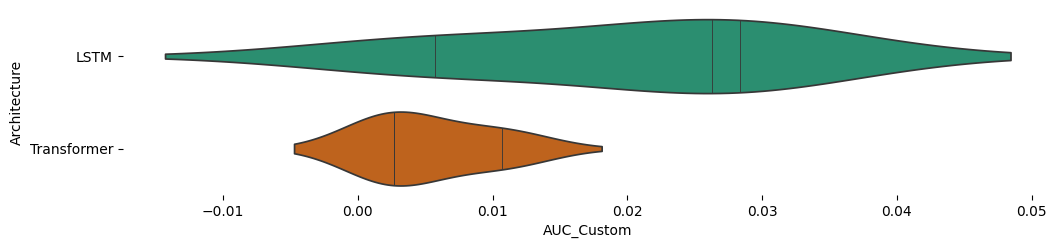

In [10]:
# @title Architecture vs AUC_Custom

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Architecture'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='AUC_Custom', y='Architecture', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-11-d09950151e71>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




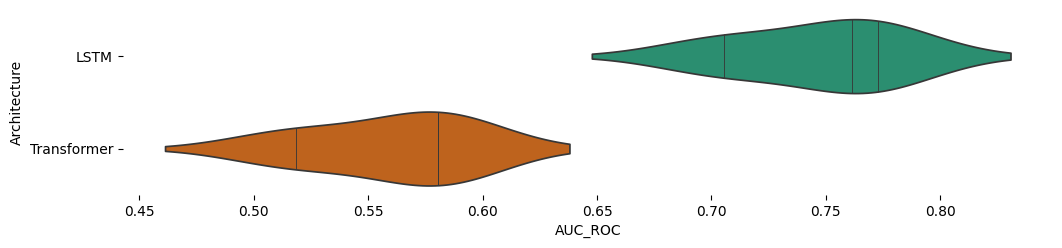

In [11]:
# @title Architecture vs AUC_ROC

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Architecture'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='AUC_ROC', y='Architecture', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-12-795624605464>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




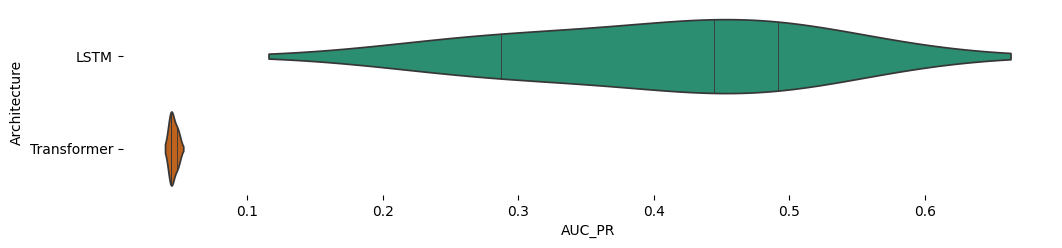

In [12]:
# @title Architecture vs AUC_PR

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Architecture'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='AUC_PR', y='Architecture', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-13-db10fe460474>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




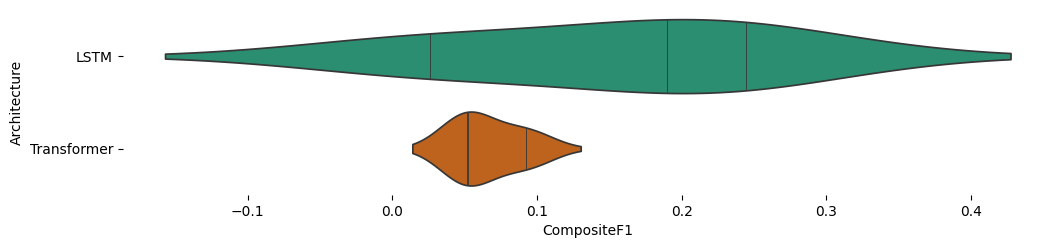

In [13]:
# @title Architecture vs CompositeF1

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Architecture'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='CompositeF1', y='Architecture', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-14-804d23751c71>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




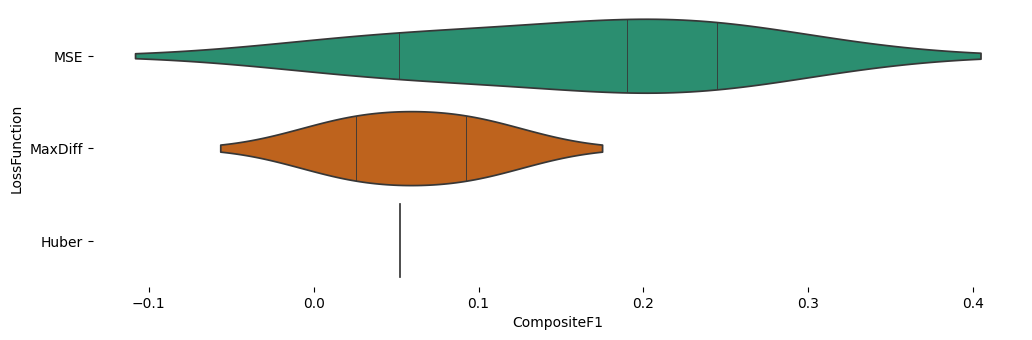

In [14]:
# @title LossFunction vs CompositeF1

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['LossFunction'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='CompositeF1', y='LossFunction', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-15-36a09d86ca15>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




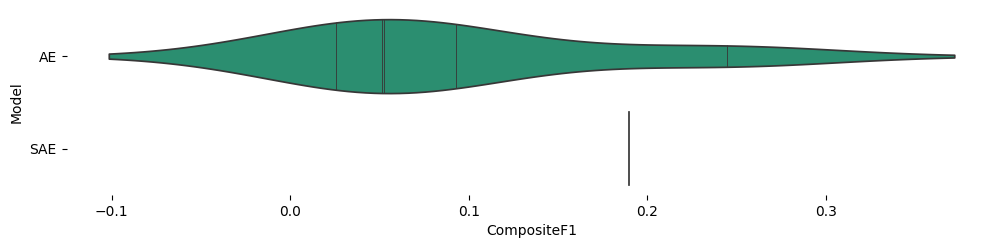

In [15]:
# @title Model vs CompositeF1

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='CompositeF1', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-16-db10fe460474>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




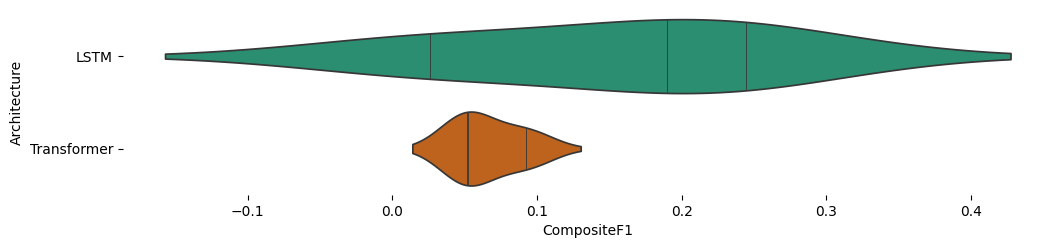

In [16]:
# @title Architecture vs CompositeF1

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(avg_metrics['Architecture'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(avg_metrics, x='CompositeF1', y='Architecture', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)